# Model Reduction on a Linear SDE

In [3]:
include("modgen_LSDE.jl")
include("..\\..\\Tools\\Model_Reduction_Dev.jl")

vector_wiener_filter_fft

In [4]:
using JLD
using PyPlot
using DSP: nextfastfft
using Distributions

the model is
$$dX_t = AX_tdt + \sigma dW_t$$
my implementation of Euler-Maruyama produces
$$ X_{n+1} = (1 + hA)X_n + \sqrt{h}\sigma u_n \qquad \text{where }u_n \sim N(0,1)$$

## Generate the data 

In [ ]:
A = reshape([-0.5],1,1)
σ = reshape([1],1,1)
Xo = [1]
t_disc = 1000
gap = 1
scheme = "EM"

t_start = 0
t_stop  = 1e4
h       = 1e-2

Δt      = h*gap
M_out   = 20

n = 2
p = 150

X = modgen_LSDE(t_start,t_stop,h,
    A = A,
    σ = σ,
    Xo = Xo,
    t_disc = t_disc,
    gap = gap)

d, N = size(X)

nfft = nextfastfft(N)
X = [X zeros(d,nfft-N)]


τ_exp, τ_int    = auto_times(X[:])*Δt

In [27]:
N_eff           = N*Δt/τ_int

4790.561376197866

In [5]:
Psi(x) = x

Psi (generic function with 1 method)

In [11]:
n = 2
p = 150
ty = "bin"
par = 2000

@time h_wf = get_wf(X, Psi; par,n,p,ty);
X = X[:,1:N]

2000

In [8]:
h_wf

1×1×20 Array{Float64,3}:
[:, :, 1] =
 0.9958567048108505

[:, :, 2] =
 0.00019069818685309793

[:, :, 3] =
 0.002028936210530662

...

[:, :, 18] =
 -0.0006543427029422169

[:, :, 19] =
 -0.0009620537888861605

[:, :, 20] =
 0.0001933916010860503

### Dive into `get_wf`

Here we dive into the `get_wf` function and take a look at how it is approximating a few things. 

In [9]:
signal = X # Vector valued process
Psi # column vector valued function

M_out = 20
rl = true
Preds = false
PI = false
rtol = 1e-6

# We would like a presample since we want the
# times series to be offset by one.

sig = signal[:,2:end] # sig is now one a head of signal
d, steps = size(sig)
nu = size(Psi(zeros(d,1)),1)

pred = complex(zeros(nu, steps))
for n = 1:steps
    pred[:,n] = Psi(signal[:,n])
end # pred is now even with signal and therefore one step
    # step behind sig. I.e. pred[:,n] = Psi(sig[:,n-1])
    # which is what we want so as to ensure the reduced
    # model can run explicitly.

#### Dive into `vector_wiener_filter_fft(sig, pred; M_out,n, p, par, ty, PI, rtol)`

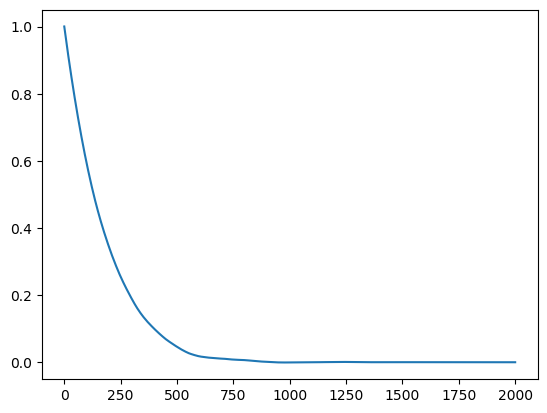

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005BDF5A48>

In [13]:
win = "Par"

d, stepsy = size(sig)
nu, stepsx = size(pred)

stepsx == stepsy || print("X and Y are not the same length. Taking min.")
steps = minimum([stepsx stepsy])
nfft = nextfastfft(steps)
nffth = Int(floor(nfft/2))
L = par

R_pred_smoothed = matrix_autocov_seq(pred,
   L = L,
   steps = steps,
   nu = nu,
   win = win
   )

plot(real(R_pred_smoothed[1,1,:]))

In [15]:
# Compute coefficients of spectral factorization of z-spect-pred
l = PI ? spectfact_matrix_CKMS_pinv(R_pred_smoothed,rtol = rtol) :
         spectfact_matrix_CKMS(R_pred_smoothed)

l_pad_minus = nfft >= L+1 ? cat(dims = 3,l,zeros(nu,nu,nfft - L - 1)) :
                           l[:,:,1:nfft]

z_spect_pred_minus_num_fft = fft(l_pad_minus,3)
z_spect_pred_plus_num_fft = complex(zeros(nu,nu,nfft))
for i = 1 : nfft
    z_spect_pred_plus_num_fft[:,:,i] = z_spect_pred_minus_num_fft[:,:,i]'
end

Number of CKMS iterations: 1203
errK errR : 8.933340289962943e-12 2.6739370740147666e-17


In [17]:
#recovered spectral density of pred
z_spect_pred_recoverd = complex(zeros(nu,nu,nfft))
for i = 1 : nfft
    z_spect_pred_recoverd[:,:,i] =z_spect_pred_minus_num_fft[:,:,i]*
                                  z_spect_pred_plus_num_fft[:,:,i]
end

z_spect_pred = z_crossspect_fft(pred, pred,
                    nfft = nfft, n = 2, p = 150, ty = "bin");

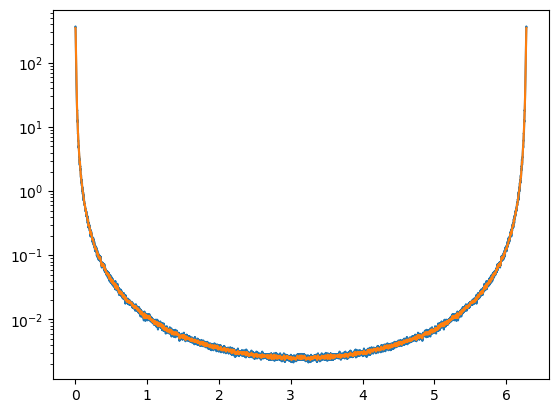

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005B02CF88>
 PyObject <matplotlib.lines.Line2D object at 0x0000000052557E08>

In [21]:
semilogy(2π*(1:nfft)/nfft,[real(z_spect_pred[1,1,
                :]) real(z_spect_pred_recoverd[1,1,
                :])]) # z_spect_pred[1,2,
                #:] z_spect_pred[2,2,:]]))
# axis([0,2000,-20,300])

In [14]:
# Compute z-cross-spectrum of sigpred
z_crossspect_sigpred_num_fft = z_crossspect_fft(sig, pred;
                    nfft, n, p, ty);

Number of CKMS iterations: 1203
errK errR : 8.933340289962943e-12 2.6739370740147666e-17


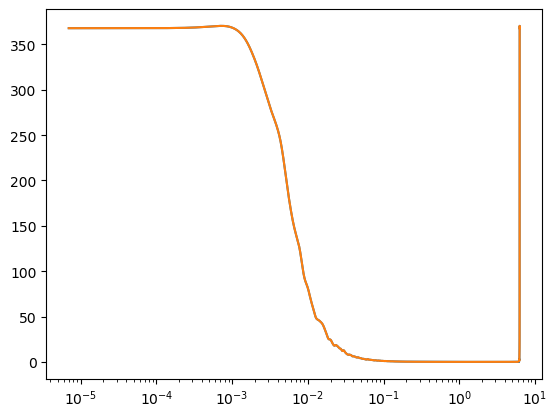

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005B039648>
 PyObject <matplotlib.lines.Line2D object at 0x0000000065F48448>

In [26]:
Theta = 2π*(1:nfft)/nfft

uz_spect_pred = real([exp(-Theta[i]*im)*z_spect_pred[1,1,i] for i in 1:nfft])

semilogx(2π*(1:nfft)/nfft,[real(z_crossspect_sigpred_num_fft[1,1,:]) uz_spect_pred])

In [5]:
(τ_exp, N_eff)

(1.985312900169461, 4509.632473376151)

In [6]:
1 .+ h*A

1×1 Array{Float64,2}:
 0.995

In [15]:
h_wf

1×1×20 Array{Float64,3}:
[:, :, 1] =
 0.99510660436287

[:, :, 2] =
 0.00035087789232835154

[:, :, 3] =
 -0.002344237451260443

...

[:, :, 18] =
 0.0002321026482148119

[:, :, 19] =
 -0.0011552980747423407

[:, :, 20] =
 0.00010824348022824984

## Get reduced (reproduced) model (no noise) 

In [28]:
# d, N  = size(X)
# nu    = size(Psi(X[:,1]),1) 
# M_out = size(h_wf,3)

# X_rm = zeros(d,N); X_rm[:,1:M_out] = X[:,1:M_out]

# PSI = zeros(nu,N); 
# for i = 1:M_out
#     PSI[:,i] = Psi(X_rm[:,i])
# end

# for i = M_out + 1 : N
#     X_rm[:,i] = sum(h_wf[:,:,k]*PSI[:,i-k] for k = 1:M_out, dims = 2)
#     PSI[:,i] = Psi(X_rm[:,i])
# end



## Get reduced (reproduced) model with noise

In [29]:
d, N  = size(X)
nu    = size(Psi(X[:,1]),1) 
M_out = 2 #size(h_wf,3)

X_rm = zeros(d,N); X_rm[:,1:M_out] = X[:,1:M_out]

PSI = zeros(nu,N); 
for i = 1:M_out
    PSI[:,i] = Psi(X_rm[:,i])
end

for i = M_out + 1 : N
    X_rm[:,i] = sum(h_wf[:,:,k]*PSI[:,i-k] for k = 1:M_out, dims = 2) + sqrt(h)*σ*randn(d)
    PSI[:,i] = Psi(X_rm[:,i])
end

In [30]:
X_rm

1×9900001 Array{Float64,2}:
 -0.781925  -0.749833  -0.622137  -0.680348  …  -2.28985  -2.20863  -2.10841

In [31]:
data = Dict(
        "h_wf" => h_wf,
        "A" => A,
        "σ" => σ,
        "Xo" => Xo,
        "t_disc" => t_disc,
        "gap" => gap,
        "scheme" => scheme,
        "t_start" => t_start,
        "t_stop" => t_start,
        "h" => h,
        "X_55" => X,
        "X__rm_55_h_4" => X_rm)

save("LSDE_Data\\LSDE_wfs_M$M_out.jld",data)

HDF5-DIAG: Error detected in HDF5 (1.10.5) thread 0:
  #000: E:/mingwbuild/mingw-w64-hdf5/src/hdf5-1.10.5/src/H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: E:/mingwbuild/mingw-w64-hdf5/src/hdf5-1.10.5/src/H5Fint.c line 1509 in H5F_open(): unable to open file: time = Fri Oct 02 10:56:30 2020
, name = 'LSDE_Data\LSDE_wfs_M2.jld', tent_flags = 13
    major: File accessibilty
    minor: Unable to open file
  #002: E:/mingwbuild/mingw-w64-hdf5/src/hdf5-1.10.5/src/H5FD.c line 734 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #003: E:/mingwbuild/mingw-w64-hdf5/src/hdf5-1.10.5/src/H5FDsec2.c line 346 in H5FD_sec2_open(): unable to open file: name = 'LSDE_Data\LSDE_wfs_M2.jld', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302
    major: File accessibilty
    minor: Unable to open file


LoadError: Error creating file LSDE_Data\LSDE_wfs_M2.jld

In [33]:
data = load("LSDE_Data\\LSDE_wfs_M10.jld")

LoadError: File LSDE_Data\LSDE_wfs_M10.jld cannot be found

In [34]:
blup = findall(isnan,X_rm[1,:])[1]

LoadError: BoundsError: attempt to access 0-element Array{Int64,1} at index [1]

In [35]:
findall(x -> x > 10^1,X_rm[1,:])[1]

LoadError: BoundsError: attempt to access 0-element Array{Int64,1} at index [1]

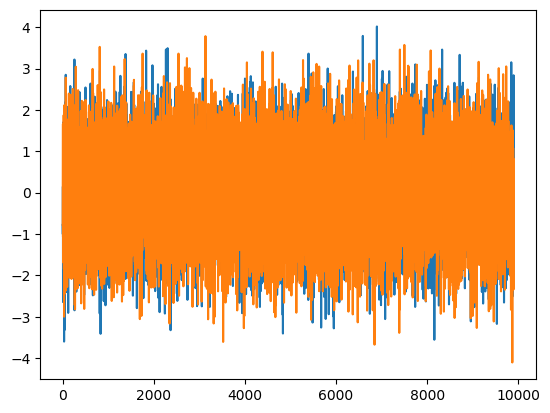

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000048877288>
 PyObject <matplotlib.lines.Line2D object at 0x0000000044AA85C8>

In [36]:
plot([X[1:1000:end] X_rm[1:1000:end]])

In [37]:
m = mean(X[1:9900001])
m_rm = mean(X_rm[1:9900001])
v = var(X[1:9900001])
v_rm = var(X_rm[1:9900001])

dist_rm = Normal(m_rm,v_rm)

f_rm(x) = pdf(dist_rm, x)

NN = 1000
XX = -5:1/NN:5

-5.0:0.001:5.0

In [38]:
plot(XX,f.(XX),":",label = "orig normal")
plot(XX,f_rm.(XX),":",label = "rm normal")

LoadError: UndefVarError: f not defined

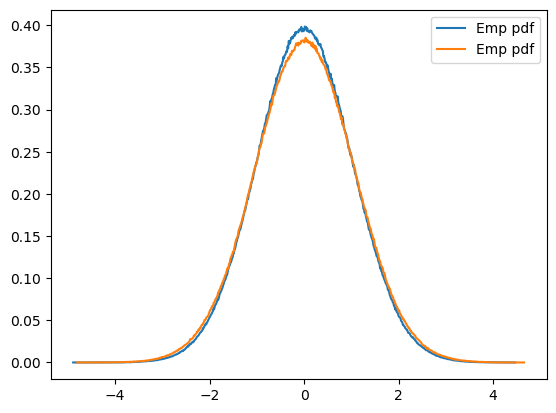

PyObject <matplotlib.legend.Legend object at 0x0000000047F905C8>

In [39]:
emp_pdf(X[1:9900001]);
emp_pdf(X_rm[1:9900001]);

legend()

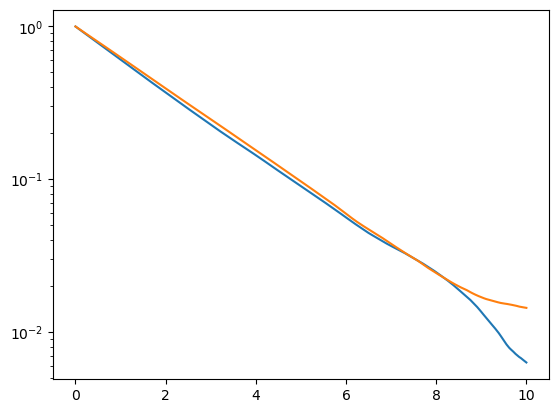

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000452DB448>
 PyObject <matplotlib.lines.Line2D object at 0x0000000044AF2148>

In [40]:
lags = 0:1000

A_rm = my_autocor(X_rm[:],lags)
A    = my_autocor(X[:],lags) 

semilogy(lags*h,[A A_rm])

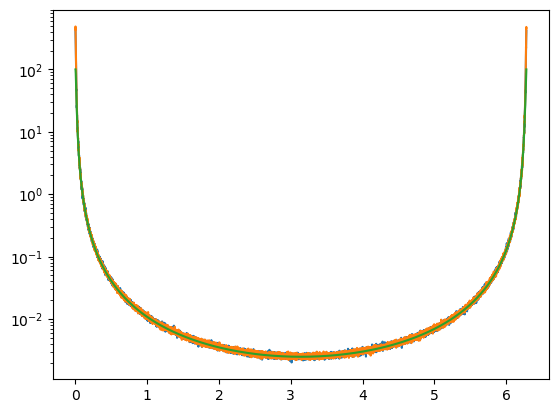

3-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000045AD7EC8>
 PyObject <matplotlib.lines.Line2D object at 0x0000000045AFBB48>
 PyObject <matplotlib.lines.Line2D object at 0x0000000045AFBD08>

In [41]:
z_spect = z_spect_scalar(X[:], n = 3, p=100, ty = "ave")
z_spect_rm = z_spect_scalar(X_rm[:], n = 3, p=100, ty = "ave")

Θ = 2*π*(1:1000:nfft)/nfft
Z = exp.(im*Θ)

a = 1 + h*A[1,1]
z_spect_ana_fun(z) = h*σ/( (1-a*z^(-1))*(1-a*z) )
z_spect_ana = real(z_spect_ana_fun.(Z))

semilogy(Θ,[z_spect[1:1000:nfft] z_spect_rm[1:1000:nfft] z_spect_ana])